# Tracking a Panda: When Smoothers Fail
#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


## Part I - Forward–Backward Exponential Smoothing

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_shaky_random_walk(n_points=300, sigma_w_sq=28**2, sigma_eta_sq=97**2, init_pos=10):
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta
    return Xi, z

def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha

def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s

def running_mean(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    result = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return np.concatenate([[result[0]]*(window_size-1), result])

def forward_backward_exponential_smoothing(z, alpha):
    forward = exponential_smoothing(z, alpha)
    backward = exponential_smoothing(forward[::-1], alpha)[::-1]
    return backward


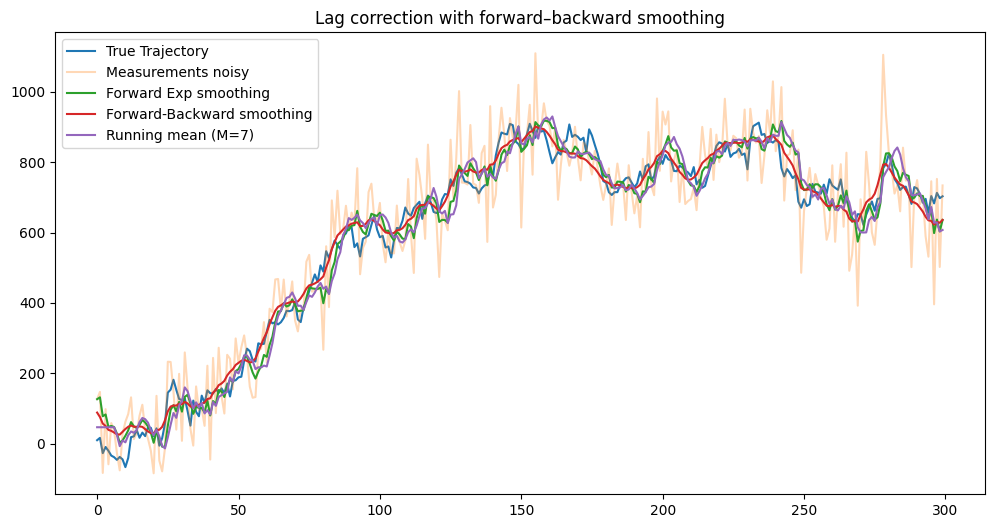

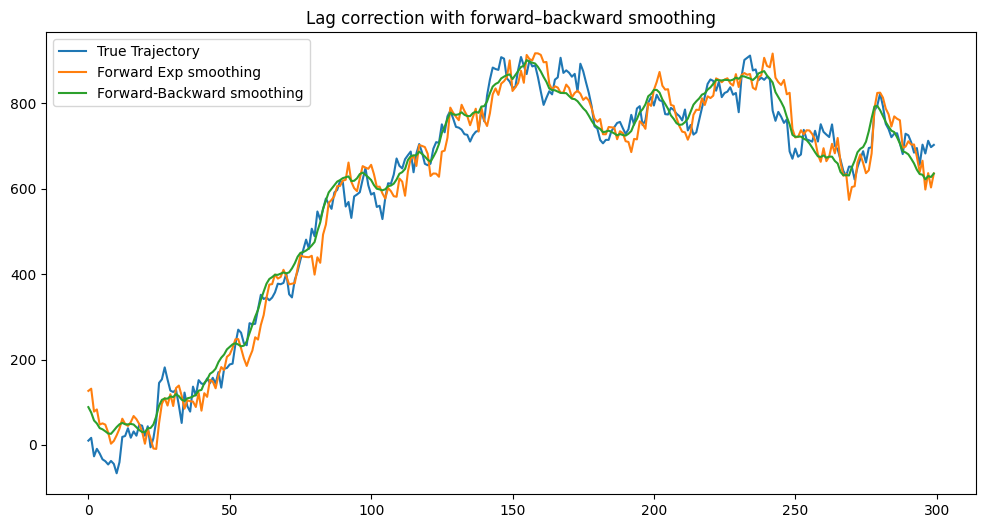

In [68]:
sigma_w2_shaky = 28**2
sigma_eta2_shaky = 97**2
alpha_shaky = calc_optimal_alpha(sigma_w2_shaky, sigma_eta2_shaky)
Xi, z = simulate_shaky_random_walk()
es_forward = exponential_smoothing(z, alpha_shaky)
es_fb = forward_backward_exponential_smoothing(z, alpha_shaky)
M = round((2 - alpha_shaky) / alpha_shaky)
rm = running_mean(z, M)

plt.figure(figsize=(12,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.plot(rm, label=f'Running mean (M={M})')
plt.legend()
plt.title('Lag correction with forward–backward smoothing')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(Xi, label='True Trajectory')
plt.plot(es_forward, label='Forward Exp smoothing')
plt.plot(es_fb, label='Forward-Backward smoothing')
plt.legend()
plt.title('Lag correction with forward–backward smoothing')
plt.show()

## Part II. A. "Sun-nap stroll": Slow Motion, Heavy Noise
We simulate panda motion with slowly changing velocity and compare running mean and exponential smoothing.

In [59]:
def simulate_sun_nap(n_points=300, T=0.1, sigma_a2=10, sigma_eta2=500):
    a = np.random.normal(0, np.sqrt(sigma_a2), n_points)
    X = np.zeros(n_points)
    V = np.zeros(n_points)
    X[0], V[0] = 5, 0
    for i in range(1, n_points):
        X[i] = X[i-1] + V[i-1]*T + 0.5*a[i-1]*T**2
        V[i] = V[i-1] + a[i-1]*T
    eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
    z = X + eta
    return X, z


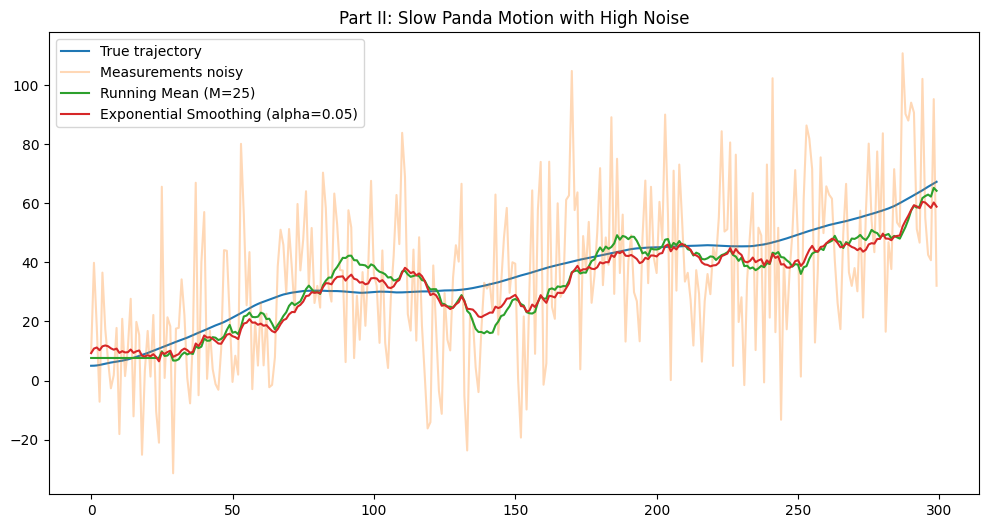

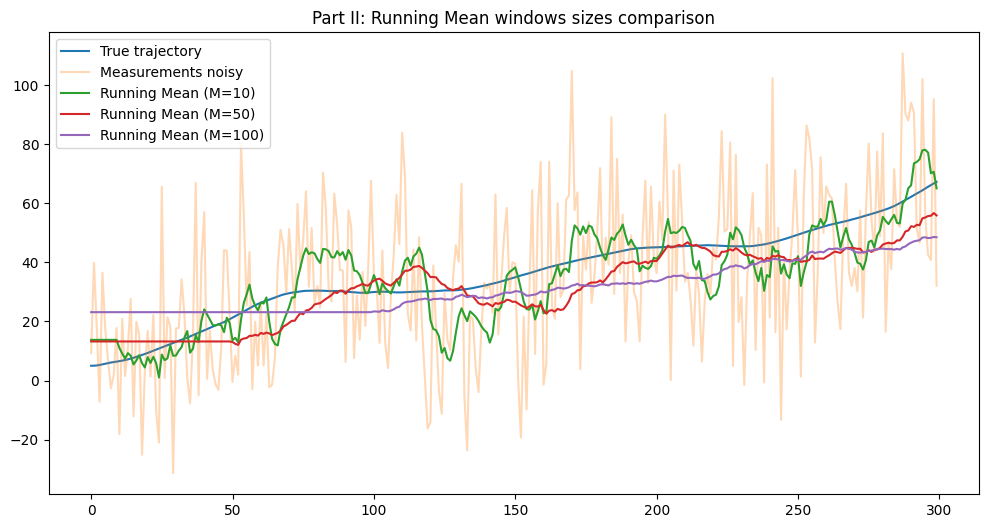

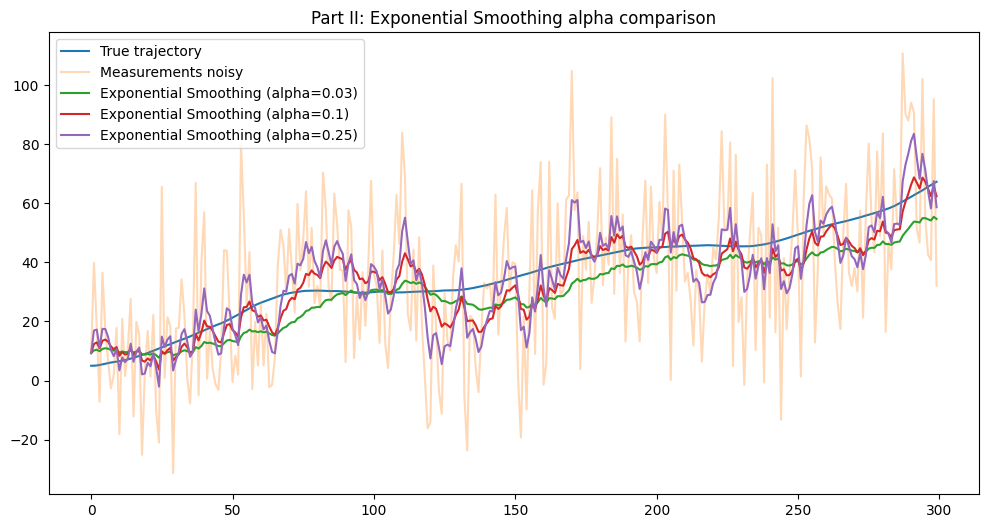

In [73]:
X_true, z = simulate_sun_nap()

M_opt = 25  # Empirically chosen window size
alpha_test = 0.05  # Small smoothing coefficient for slow motion

rm_est = running_mean(z, M_opt)
es_est = exponential_smoothing(z, alpha_test)

plt.figure(figsize=(12,6))
plt.plot(X_true, label='True trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
plt.plot(rm_est, label=f'Running Mean (M={M_opt})')
plt.plot(es_est, label=f'Exponential Smoothing (alpha={alpha_test})')
plt.legend()
plt.title('Part II: Slow Panda Motion with High Noise')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(X_true, label='True trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
for M in [10, 50, 100]:
    rm_est = running_mean(z, M)
    plt.plot(rm_est, label=f'Running Mean (M={M})')
plt.legend()
plt.title('Part II: Running Mean windows sizes comparison')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(X_true, label='True trajectory')
plt.plot(z, alpha=0.3, label='Measurements noisy')
for alpha in [0.03, 0.1, 0.25]:
    es_est = exponential_smoothing(z, alpha)
    plt.plot(es_est, label=f'Exponential Smoothing (alpha={alpha})')
plt.legend()
plt.title('Part II: Exponential Smoothing alpha comparison')
plt.show()



# Part II. B. Cyclic Motion in Rolling Bamboo Hills

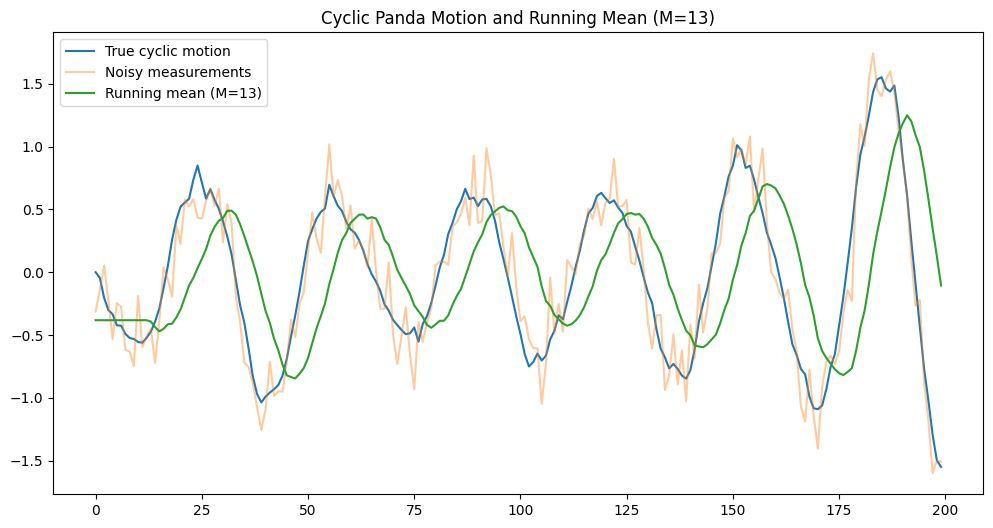

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
n_points = 200
T = 32
sigma_w2 = 0.08**2
sigma_eta2 = 0.05
M = 13 

omega = 2 * np.pi / T

A = np.zeros(n_points)
X = np.zeros(n_points)
A[0] = 1.0

for i in range(1, n_points):
    wi = np.random.normal(0, np.sqrt(sigma_w2))
    A[i] = A[i-1] + wi
    X[i] = A[i] * np.sin(omega * i + 3)

eta = np.random.normal(0, np.sqrt(sigma_eta2), n_points)
z = X + eta

rm_est = running_mean(z, M)

plt.figure(figsize=(12,6))
plt.plot(X, label='True cyclic motion')
plt.plot(z, alpha=0.4, label='Noisy measurements')
plt.plot(rm_est, label=f'Running mean (M={M})')
plt.legend()
plt.title('Cyclic Panda Motion and Running Mean (M=13)')
plt.show()

## Oscillation Period Analysis
Test how the running mean with window size 13 affects signals with different periods.

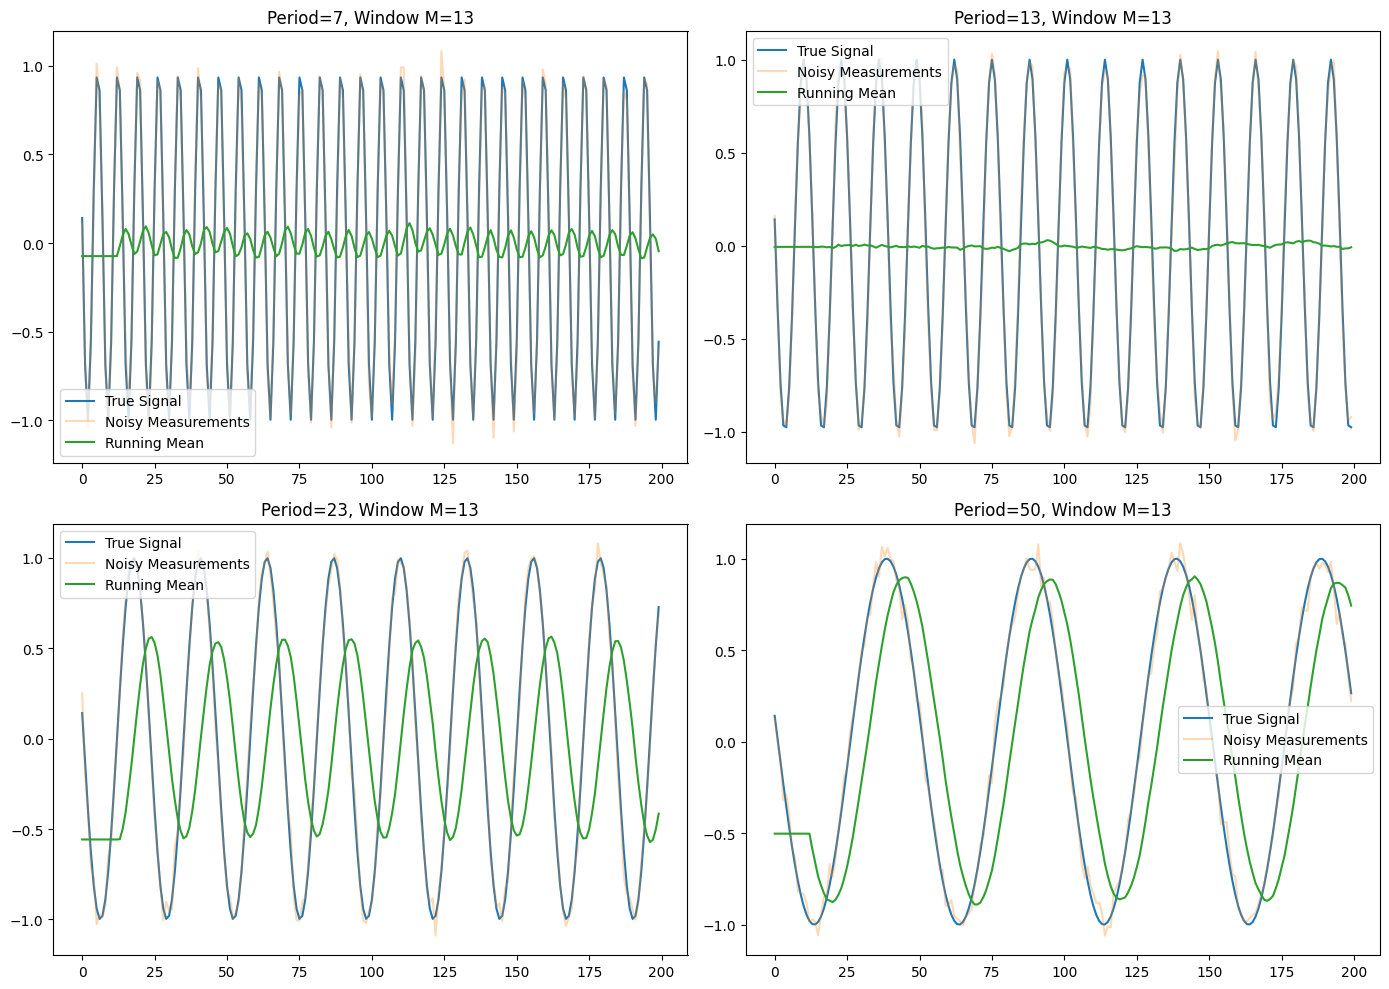

In [65]:
def generate_cyclic_motion(T, n_points=200, M=13):
    omega = 2 * np.pi / T
    A = np.ones(n_points)  # fixed amplitude for clarity
    X = A * np.sin(omega * np.arange(n_points) + 3)
    z = X + np.random.normal(0, 0.05, n_points)  # small noise
    rm = running_mean(z, M)
    return X, z, rm

periods = [7, 13, 23, 50]
plt.figure(figsize=(14,10))
for idx, period in enumerate(periods, 1):
    X, z, rm = generate_cyclic_motion(T=period, n_points=200, M=13)
    plt.subplot(2,2,idx)
    plt.plot(X, label='True Signal')
    plt.plot(z, alpha=0.3, label='Noisy Measurements')
    plt.plot(rm, label='Running Mean')
    plt.title(f'Period={period}, Window M={M}')
    plt.legend()

plt.tight_layout()
plt.show()

## Conclusions
- When the period is much smaller than the window size, the running mean causes inverse oscillations due to signal aliasing.
- When the period is close to the window size, running mean can eliminate oscillations.
- When the period is larger than the window size, the running mean smooths noise but retains oscillation shape.
- Therefore, the running mean window size relative to the oscillation period critically affects the output.